**Introduction :**

Time Series Forecasting means analyzing and modeling time-series data to make future decisions. Some of the applications of Time Series Forecasting are weather forecasting, sales forecasting, business forecasting, stock price forecasting, etc. The ARIMA model is a popular statistical technique used for Time Series Forecasting. 

ARIMA stands for Autoregressive Integrated Moving Average. It is an algorithm used for forecasting Time Series Data. ARIMA models have three parameters like ARIMA(p, d, q). Here p, d, and q are defined as:

**p** is the number of lagged values that need to be added or subtracted from the values (label column). It captures the autoregressive part of ARIMA.

**d **represents the number of times the data needs to differentiate to produce a stationary signal. If it’s stationary data, the value of d should be 0, and if it’s seasonal data, the value of d should be 1. d captures the integrated part of ARIMA.

**q** is the number of lagged values for the error term added or subtracted from the values (label column). It captures the moving average part of ARIMA.

In [145]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
#today = date.today()
today= datetime.date(2023, 5, 1)
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=3*365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('PLUG', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.tail())

          Date  Open  High   Low  Close  Adj Close    Volume
742 2023-04-24  9.01  9.35  8.83   9.27       9.27  15612100
743 2023-04-25  9.12  9.13  8.76   8.91       8.91  15692300
744 2023-04-26  8.89  8.89  8.37   8.47       8.47  24227800
745 2023-04-27  8.65  9.16  8.65   8.97       8.97  20213200
746 2023-04-28  8.96  9.16  8.79   9.03       9.03  11943000


We only need the date and close prices columns

In [146]:
data = data[["Date", "Close"]]
print(data.head())

        Date  Close
0 2020-05-12   4.28
1 2020-05-13   4.11
2 2020-05-14   4.06
3 2020-05-15   4.08
4 2020-05-18   4.17


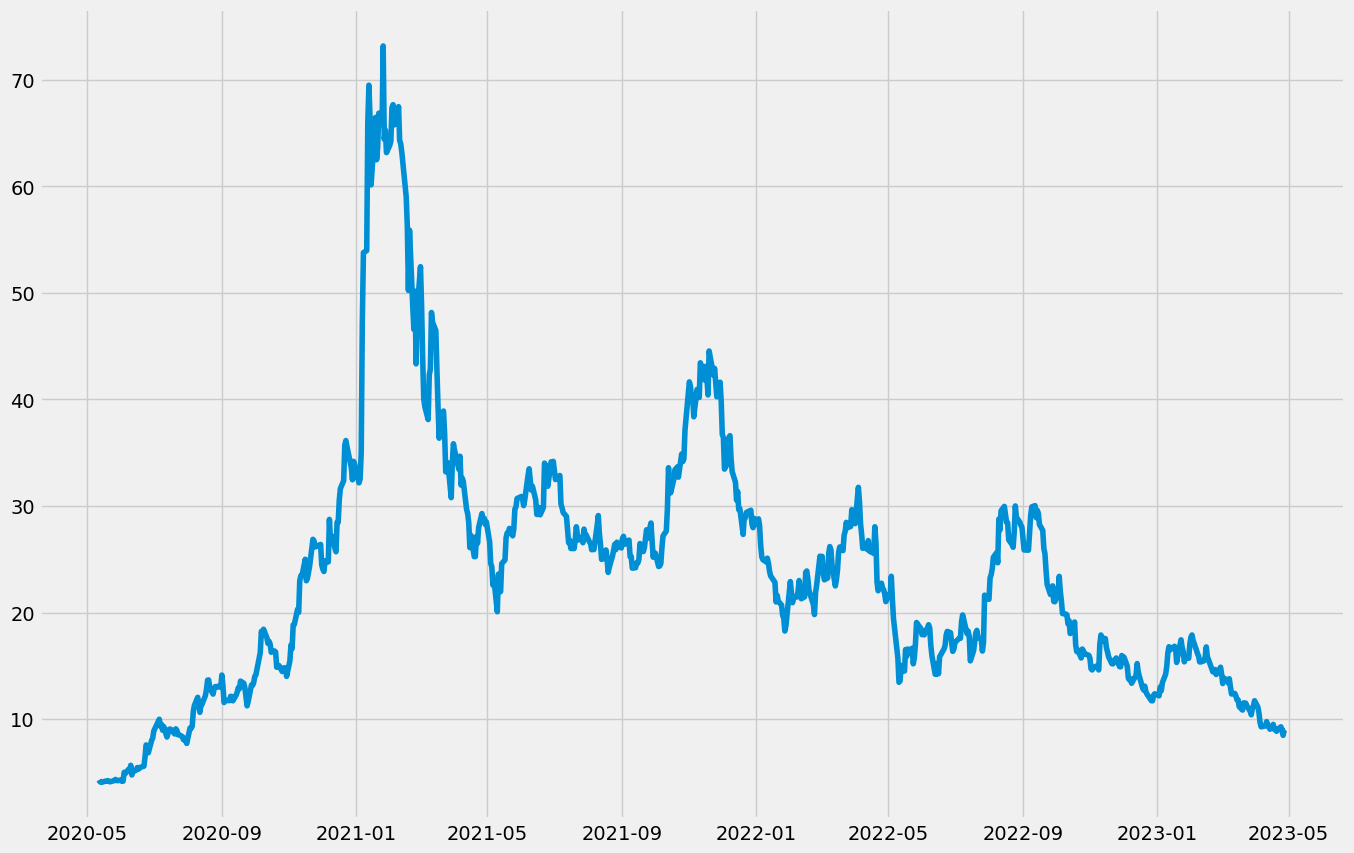

In [147]:
# visualize the close prices of Google
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

Before using the ARIMA model, we have to figure out whether our data is stationary or seasonal. The data visualization graph about the closing stock prices above shows that our dataset is not stationary. To check whether our dataset is stationary or seasonal properly, we can use the seasonal decomposition method that splits the time series data into trend, seasonal, and residuals for a better understanding of the time series data.

Seasonal decomposition : https://otexts.com/fpp2/components.html

<Figure size 640x480 with 0 Axes>

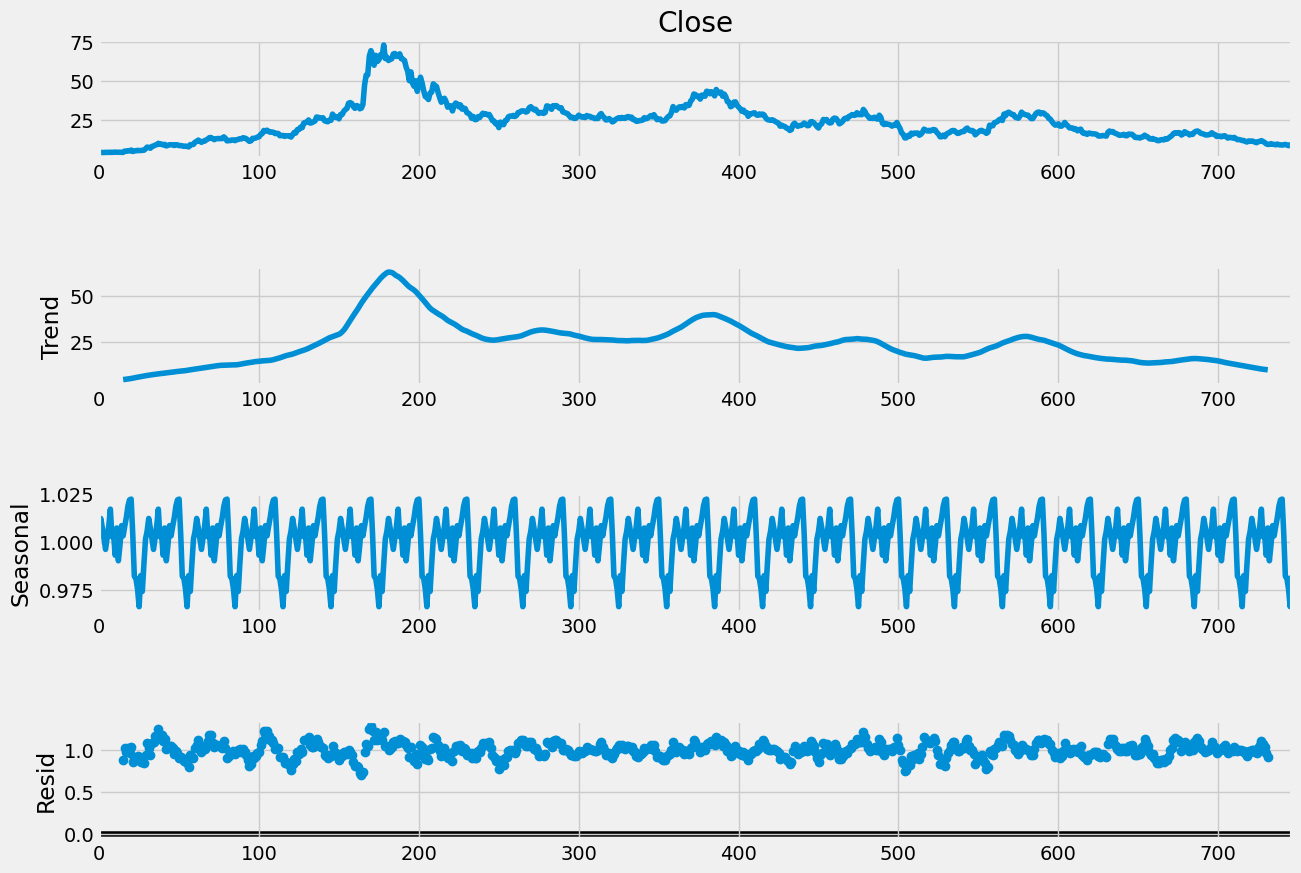

In [148]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"],model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

So our data is not stationary it is seasonal. We need to use the Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data. But before using the SARIMA model, we will use the ARIMA model. 

To use ARIMA or SARIMA, we need to find the p, d, and q values. We can find the value of p by plotting the autocorrelation of the Close column and the value of q by plotting the partial autocorrelation plot. The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

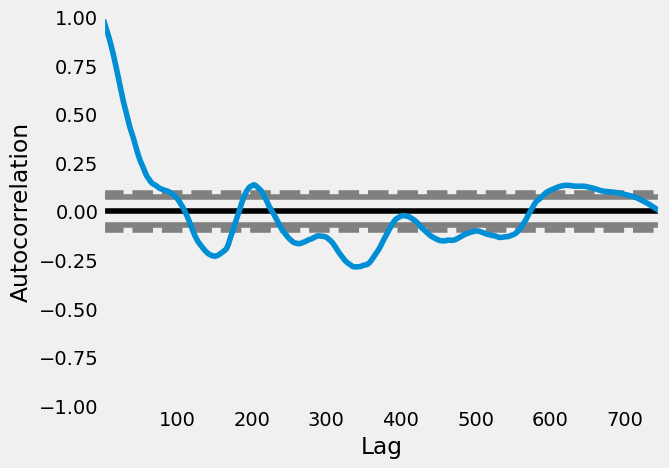

In [149]:
#finding the value of p:

pd.plotting.autocorrelation_plot(data["Close"])


In the above autocorrelation plot, the curve is moving down after the 5th line of the first boundary. That is how to decide the p-value. Hence the value of p is 5.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


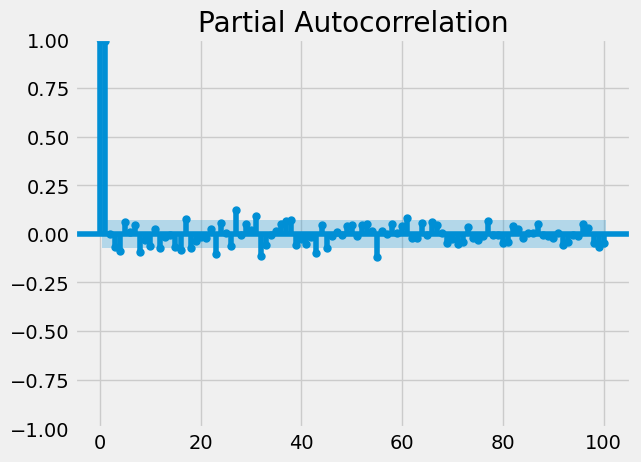

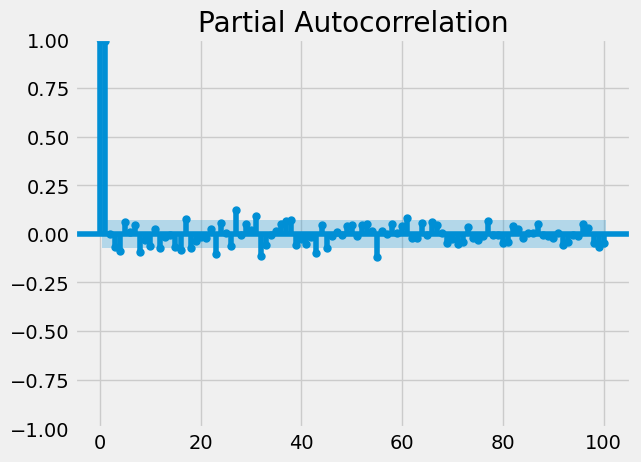

In [150]:
#let’s find the value of q (moving average)
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags = 100)

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how to decide the q value. Hence the value of q is 2. 

In [168]:
#let’s build an ARIMA model
p, d, q = 4, 1, 2
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data["Close"], order=(p,d,q))  
fitted = model.fit()  
print(fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  747
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -1397.989
Date:                Fri, 12 May 2023   AIC                           2809.978
Time:                        20:48:05   BIC                           2842.281
Sample:                             0   HQIC                          2822.428
                                - 747                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0993      0.032      3.068      0.002       0.036       0.163
ar.L2          0.9525      0.037     25.931      0.000       0.880       1.024
ar.L3          0.0678      0.018      3.856      0.0

In [169]:
predictions = fitted.predict()
print(predictions)

0      0.000000
1      4.280000
2      4.111578
3      4.049487
4      4.064916
         ...   
742    9.262646
743    9.175845
744    9.134529
745    8.373847
746    9.095685
Name: predicted_mean, Length: 747, dtype: float64


In [170]:
predictions = fitted.predict(len(data), len(data)+10)
print(predictions)

#           Date  Open  High   Low  Close  Adj Close    Volume
# 246 2023-05-05  8.95  9.40  8.93   9.29       9.29  17587300
# 247 2023-05-08  9.47  9.50  9.05   9.29       9.29  16994000
# 248 2023-05-09  8.68  8.85  7.91   8.01       8.01  53930100
# 249 2023-05-10  8.13  8.18  7.73   7.83       7.83  21750200
# 250 2023-05-11  7.77  7.89  7.48   7.65       7.65  25825200

747    8.994743
748    9.199371
749    9.124846
750    9.302122
751    9.267226
752    9.400823
753    9.402611
754    9.504508
755    9.529950
756    9.612198
757    9.651275
Name: predicted_mean, dtype: float64


The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model

In [171]:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  747
Model:             SARIMAX(4, 1, 2)x(4, 1, 2, 12)   Log Likelihood               -1402.051
Date:                            Fri, 12 May 2023   AIC                           2830.102
Time:                                    20:49:48   BIC                           2889.883
Sample:                                         0   HQIC                          2853.160
                                            - 747                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1139      0.316     -0.361      0.718      -0.733       0.505
ar.L2          0.7947      0.289   

In [156]:
predictions = model.predict(len(data), len(data)+10)
print(predictions)

#           Date  Open  High   Low  Close  Adj Close    Volume
# 246 2023-05-05  8.95  9.40  8.93   9.29       9.29  17587300
# 247 2023-05-08  9.47  9.50  9.05   9.29       9.29  16994000
# 248 2023-05-09  8.68  8.85  7.91   8.01       8.01  53930100
# 249 2023-05-10  8.13  8.18  7.73   7.83       7.83  21750200
# 250 2023-05-11  7.77  7.89  7.48   7.65       7.65  25825200

747    8.892848
748    8.899029
749    8.999562
750    8.830544
751    8.786766
752    8.749937
753    8.593822
754    8.709290
755    8.826826
756    8.724211
757    8.827710
Name: predicted_mean, dtype: float64


<Axes: >

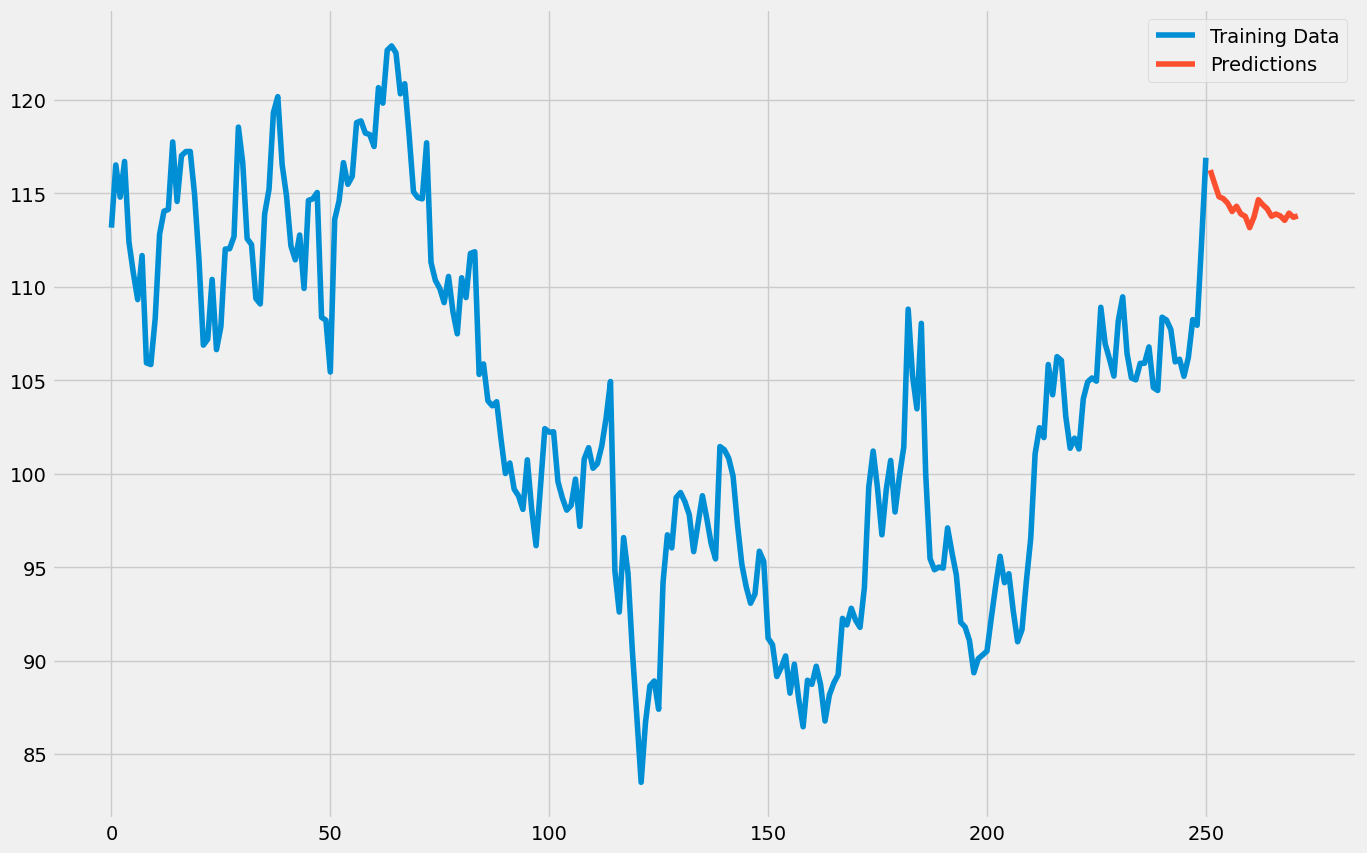

In [87]:
#plotting the predictions 
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")